<h1>William Kiger</h1> 
<p>CS 410 Text information Systems</p>
<p>Fall 2022</p>
<p>Group -- Bean</p>

In [1]:
# References: 
# https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
# https://bentrevett.com/
# https://pytorch.org/tutorials/beginner/torchtext_translation.html?highlight=transformer
# https://www.alldatascience.com/nlp/nlp-sentiment-analysis-with-pytorch/

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from torchtext import data, datasets
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
init_token_id = tokenizer.cls_token_id
eos_token_id  = tokenizer.sep_token_id
pad_token_id  = tokenizer.pad_token_id
unk_token_id  = tokenizer.unk_token_id

In [4]:
max_size = tokenizer.max_model_input_sizes['bert-base-uncased']

def trim_tokenize(text):
    
    tok = tokenizer.tokenize(text)
    tok = tok[:max_size - 2]
    
    return tok

In [5]:
#discovered the IMDB movie reviews is a big dataset with lots of text like in our case.  
#this code is grabbing the data from pytorch https://pytorch.org/text/_modules/torchtext/datasets/imdb.html
#also provided is the csv files for this dataset.  
text = data.Field(
    batch_first=True,
    use_vocab=False,
    tokenize=trim_tokenize,
    preprocessing=tokenizer.convert_tokens_to_ids,
    init_token=init_token_id,
    pad_token=pad_token_id,
    unk_token=unk_token_id
)

label = data.LabelField(dtype=torch.float)

train_data, test_data  = datasets.IMDB.splits(text, label)
train_data, valid_data = train_data.split(random_state=random.seed(1234))

label.build_vocab(train_data)

train_iter, valid_iter, test_iter = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=16,
    device=device)

In [6]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
#this is the sentiment model with the idea taken from: https://bentrevett.com/
#it uses the pretrained BERT model developed by Google and is considered cutting edge
#in around 11 NLP areas (my paper discussed this topic).  This model contains a linear
#layer for the text classification

class BertSentimentModel(nn.Module):
    
    def __init__(self,bert,hidden_dim,output_dim,n_layers,bidirectional,dropout):
        super(BertSentimentModel, self).__init__()
    
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        self.rnn = nn.GRU(
          embedding_dim,
          hidden_dim,
          num_layers=n_layers,
          bidirectional=bidirectional,
          batch_first=True,
          dropout=0 if n_layers < 2 else dropout
        )
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
      
    def forward(self, text):
        with torch.no_grad():
            embedded = self.bert(text)[0]
            
        _, hidden = self.rnn(embedded)
    
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
    
        output = self.out(hidden)
        
        return output

model = BertSentimentModel(bert_model, 256, 1, 2, True, 0.25)
#bert,hidden_dim,output_dim,n_layers,bidirectional,dropout
# print(model)

In [8]:
def compute_accuracy(preds, label): 
    rp = torch.round(torch.sigmoid(preds))
    correct = (rp == label).float()
    accuracy = correct.sum() / len(correct)
    
    return accuracy

In [9]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_accuracy = 0
    model.train()
  
    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        accuracy = compute_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
        
    training_loss = epoch_loss / len(iterator)
    train_accuracy = epoch_accuracy / len(iterator)

    return training_loss, train_accuracy

In [10]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_accuracy = 0

    model.eval()
  
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text).squeeze(1)
            loss = criterion(predictions, batch.label)
            accuracy = compute_accuracy(predictions, batch.label) 
            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()
    
    train_loss = epoch_loss / len(iterator)
    train_accuracy = epoch_accuracy / len(iterator)
    
    return train_loss, train_accuracy

In [11]:
def predict_sentiment(model, tokenizer, sentence):
    
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_size - 2] 
    indexed = [init_token_id] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_id]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    
    return prediction.item()

In [12]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss().to(device)
model = model.to(device)

train_losses_list = []
train_accuracy_list = []

best_accuracy = 0 

epochs = 8

# baseline evaluate
train_loss, train_accuracy = evaluate(model, valid_iter, criterion)

train_losses_list.append(train_loss)    
train_accuracy_list.append(train_accuracy)

for epoch in range(epochs):
    print("Processing epoch: " + str(epoch + 1)) 
    training_loss, train_accuracy = train(model, train_iter, optimizer, criterion)

#     print("train_accuracy=" + str(train_accuracy))
#     print("best_acc=" + str(best_acc))
    if train_accuracy > best_accuracy: 
        best_acc = train_accuracy
        torch.save(model.state_dict(), "sentiment_model.pt")
        print("Saved new model at epoch: " + str(epoch+1))
        
    train_losses_list.append(training_loss)    
    train_accuracy_list.append(train_accuracy)
        
    print(f'Epoch: {epoch + 1}')
    print(f'Training Loss: {training_loss:.5f}')
    print(f'Training Accuracy: {train_accuracy * 100:.5f}%')        
    print('-----------------------------')

Processing epoch: 1
Saved new model at epoch: 1
Epoch: 1
Training Loss: 0.45597
Training Accuracy: 78.19546%
-----------------------------
Processing epoch: 2
Saved new model at epoch: 2
Epoch: 2
Training Loss: 0.32793
Training Accuracy: 86.16507%
-----------------------------
Processing epoch: 3
Saved new model at epoch: 3
Epoch: 3
Training Loss: 0.28957
Training Accuracy: 88.12081%
-----------------------------
Processing epoch: 4
Saved new model at epoch: 4
Epoch: 4
Training Loss: 0.27154
Training Accuracy: 88.78923%
-----------------------------
Processing epoch: 5
Saved new model at epoch: 5
Epoch: 5
Training Loss: 0.25586
Training Accuracy: 89.62523%
-----------------------------
Processing epoch: 6
Saved new model at epoch: 6
Epoch: 6
Training Loss: 0.23776
Training Accuracy: 90.26318%
-----------------------------
Processing epoch: 7
Saved new model at epoch: 7
Epoch: 7
Training Loss: 0.23107
Training Accuracy: 90.54121%
-----------------------------
Processing epoch: 8
Saved n

In [13]:
# Checking the Testing set loss and accuracy.  Achieveing around 91% accuracy on the test set.
model.load_state_dict(torch.load('sentiment_model.pt'))
test_loss, test_accuracy = evaluate(model, test_iter, criterion) 
print(f'Test Loss: {test_loss:.5f}') 
print(f'Test Accuracy: {test_accuracy*100:.5f}%')

Test Loss: 0.22077
Test Accuracy: 91.49872%


In [14]:
TEXT = "I love Text Information Systems"
model.load_state_dict(torch.load('sentiment_model.pt', map_location=device))
test = predict_sentiment(model, tokenizer, TEXT)
print(f'Inference: {test:.2f}')

Inference: 0.62


In [15]:
TEXT = "I hate NLP"
model.load_state_dict(torch.load('sentiment_model.pt', map_location=device))
test = predict_sentiment(model, tokenizer, TEXT)
print(f'Inference: {test:.2f}')

Inference: 0.05


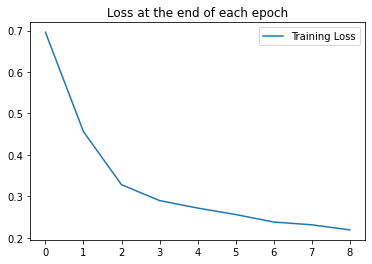

In [16]:
plt.plot(train_losses_list, label='Training Loss')
plt.title('Loss at the end of each epoch')
plt.legend();

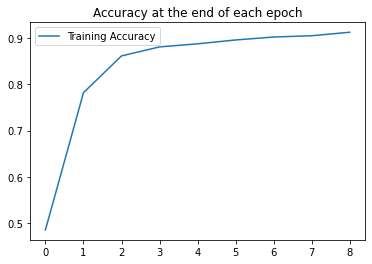

In [17]:
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [18]:
# import sys
# !conda install --yes --prefix {sys.prefix} -c pytorch torchtext